# Data storytelling: UFO phenomena

The US Congress hearing on Unidentified Flying Objects (UFOs, also known as Unidentified Aerial Phenomenon or UAP in short) that took place last July has revived public interest in these mysterious phenomena. 

Although the question of what exactly these phenomena are is obviously out of our reach, we are interested in the rich phenomenology that accompanies these events. People describe UFO in a wide variety of different shapes, the duration of reported sightings vary from seconds to hours, and some reports include the presence of impressive elements such as thunder-like sounds and colorful lights. Some places are hot spots for sightings, with a large number of reportted events. And there seems to be a seasonality component as well.

This rich variety of features encountered in UFO reports raises several questions that can serve as the seed for a storytelling based on reports statistics. Concretely, we wonder: 

How have UFO sightings numbers changed over time?

What is the typical duration of such events? 

Where are the geographical hot spots located? What regions of the globe report more sightings? 

Do clusters of UFO sightings correlate with landmarks, such as airports or government research centers?

At what time of the year is it more likely to observe a UFO? 

Is there any common characteristic in people describing these events? 

How many of the reports are made up stories? 

What are the most common shapes or types of UFOs reported?
    


In this notebook we will use a UFO dataset collected by the National UFO Report Center (NUFORC) to try to answer some of these questions. 



## Data collection

We have downloaded the NUFORC dataset available on https://www.kaggle.com/datasets/NUFORC/ufo-sightings/data?select=scrubbed.csv

Let us have a look at its columns and first entries:

In [1]:
import pandas as pd

ufo_data_path = './scrubbed.csv'
df = pd.read_csv(ufo_data_path)

# Display the first few rows of the dataframe to verify it loaded correctly
df.head()


C:\Users\sergi\AppData\Local\Temp\ipykernel_13860\649283478.py:4: DtypeWarning: Columns (5,9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(ufo_data_path)


datetime                  city state country     shape  \
0  10/10/1949 20:30            san marcos    tx      us  cylinder   
1  10/10/1949 21:00          lackland afb    tx     NaN     light   
2  10/10/1955 17:00  chester (uk/england)   NaN      gb    circle   
3  10/10/1956 21:00                  edna    tx      us    circle   
4  10/10/1960 20:00               kaneohe    hi      us     light   

  duration (seconds) duration (hours/min)  \
0               2700           45 minutes   
1               7200              1-2 hrs   
2                 20           20 seconds   
3                 20             1/2 hour   
4                900           15 minutes   

                                            comments date posted    latitude  \
0  This event took place in early fall around 194...   4/27/2004  29.8830556   
1  1949 Lackland AFB&#44 TX.  Lights racing acros...  12/16/2005    29.38421   
2  Green/Orange circular disc over Chester&#44 En...   1/21/2008        53.2   
3  My older brother and twin sister were leaving ...   1/17/2004  28.9783333   
4  AS a Marine 1st Lt. flying an FJ4B fighter/att...   1/22/2004  21.4180556   

   longitude   
0  -97.941111  
1  -98.581082  
2   -2.916667  
3  -96.645833  
4 -157.803611

We find relevant information about the date of the event, its geographical location,  its duration and the shape of the object. The comments section might provide information about subjective and psychological factors, but also about the seriousness of the event (for instance, whether the police was called, or whether the event was observed by a pilot). 

Data seems to be chronologically ordered. However, notice the repetition of the date October 10. The date posted column indicates a date decades later, so this might be some sort of systematic error. 

We may also check the number of entries in our dataset.

In [2]:
print(f"The given dataset contains {df.shape[0]} rows and {df.shape[1]} columns")

The given dataset contains 80332 rows and 11 columns


And also check for duplicated rows:

In [3]:
df[df.duplicated()]

Empty DataFrame
Columns: [datetime, city, state, country, shape, duration (seconds), duration (hours/min), comments, date posted, latitude, longitude ]
Index: []

There are no duplicated rows. We now check for null values:

In [4]:
df.isnull().sum()

datetime                   0
city                       0
state                   5797
country                 9670
shape                   1932
duration (seconds)         0
duration (hours/min)       0
comments                  15
date posted                0
latitude                   0
longitude                  0
dtype: int64

In [5]:
round(df.isna().mean() * 100, 2)

datetime                 0.00
city                     0.00
state                    7.22
country                 12.04
shape                    2.41
duration (seconds)       0.00
duration (hours/min)     0.00
comments                 0.02
date posted              0.00
latitude                 0.00
longitude                0.00
dtype: float64

Only categorical and comments columns have null values, not the numerical ones. We do not cosnider necessary to drop any columns. 

## Data cleaning

We will need to do some data cleaning on the downloaded dataset in order to process it correctly. First, let us print the names of the columns.

In [6]:
# Print the column names of the DataFrame
print(df.columns)

Index(['datetime', 'city', 'state', 'country', 'shape', 'duration (seconds)',
       'duration (hours/min)', 'comments', 'date posted', 'latitude',
       'longitude '],
      dtype='object')


The column corresponding to the longitude was originally typed with a space in the end. Let us correct this.

In [7]:
df = df.rename(columns={'longitude ': 'longitude'})

A quick way to check the data types of the columns is using .info()

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80332 entries, 0 to 80331
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   datetime              80332 non-null  object 
 1   city                  80332 non-null  object 
 2   state                 74535 non-null  object 
 3   country               70662 non-null  object 
 4   shape                 78400 non-null  object 
 5   duration (seconds)    80332 non-null  object 
 6   duration (hours/min)  80332 non-null  object 
 7   comments              80317 non-null  object 
 8   date posted           80332 non-null  object 
 9   latitude              80332 non-null  object 
 10  longitude             80332 non-null  float64
dtypes: float64(1), object(10)
memory usage: 6.7+ MB


There are a few columns that should be in float64 but are actually object type, which strongly indicates the presence of text characters in some entries. We will need to take care of this.

For the ``latitude`` column, we can eliminate the text characters in string entries and then convert to numeric type:

In [9]:
def clean_numeric(value):
    # Check if the value is a string
    if isinstance(value, str):
        # Remove any non-numeric characters, preserving decimal points
        return ''.join(c for c in value if c.isdigit() or c == '.')
    else:
        # Return the value directly if it's not a string
        return value

# Then apply this function as before
df['latitude'] = df['latitude'].apply(clean_numeric)

# Convert to numeric, handling any errors or non-convertible values
df['latitude'] = pd.to_numeric(df['latitude'], errors='coerce')

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80332 entries, 0 to 80331
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   datetime              80332 non-null  object 
 1   city                  80332 non-null  object 
 2   state                 74535 non-null  object 
 3   country               70662 non-null  object 
 4   shape                 78400 non-null  object 
 5   duration (seconds)    80332 non-null  object 
 6   duration (hours/min)  80332 non-null  object 
 7   comments              80317 non-null  object 
 8   date posted           80332 non-null  object 
 9   latitude              80332 non-null  float64
 10  longitude             80332 non-null  float64
dtypes: float64(2), object(9)
memory usage: 6.7+ MB


We need to convert the datetime column into datetime type. A special handling for cases where the time component is mistakenly set to '24' hours is required. 

In [13]:
# Replace "24:00" with "23:59"
df['datetime'] = df['datetime'].str.replace('24:00', '23:59')

df['datetime'] = pd.to_datetime(df['datetime'])

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80332 entries, 0 to 80331
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   datetime              80332 non-null  datetime64[ns]
 1   city                  80332 non-null  object        
 2   state                 74535 non-null  object        
 3   country               70662 non-null  object        
 4   shape                 78400 non-null  object        
 5   duration (seconds)    80332 non-null  object        
 6   duration (hours/min)  80332 non-null  object        
 7   comments              80317 non-null  object        
 8   date posted           80332 non-null  object        
 9   latitude              80332 non-null  float64       
 10  longitude             80332 non-null  float64       
dtypes: datetime64[ns](1), float64(2), object(8)
memory usage: 6.7+ MB


We should also add columns indicating year, month, day and hour. 

In [15]:
df["month"] = pd.DatetimeIndex(df['datetime']).month
df["year"] = pd.DatetimeIndex(df['datetime']).year
df["day"] = pd.DatetimeIndex(df['datetime']).day
df["hour"] = pd.DatetimeIndex(df['datetime']).hour

And also convert the reported date column to datetime type.

In [16]:
df['date posted'] = pd.to_datetime(df['date posted'])

The column ``duration (hours/min)`` is redundant and can be dropped.

In [17]:
df.drop(columns="duration (hours/min)", axis=1,inplace=True)

Finally we convert the type of our duration column to float.

In [20]:
# Step 1: Identify problematic values
problematic_mask = ~df['duration (seconds)'].astype(str).str.replace('.', '', 1).str.isnumeric()
problematic_values = df.loc[problematic_mask, 'duration (seconds)']

# Step 2: Correct or remove problematic values
df.loc[problematic_mask, 'duration (seconds)'] = problematic_values.astype(str).str.replace('`', '')

# Step 3: Convert the column to float
df['duration (seconds)'] = pd.to_numeric(df['duration (seconds)'], errors='coerce')

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80332 entries, 0 to 80331
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   datetime            80332 non-null  datetime64[ns]
 1   city                80332 non-null  object        
 2   state               74535 non-null  object        
 3   country             70662 non-null  object        
 4   shape               78400 non-null  object        
 5   duration (seconds)  80332 non-null  float64       
 6   comments            80317 non-null  object        
 7   date posted         80332 non-null  datetime64[ns]
 8   latitude            80332 non-null  float64       
 9   longitude           80332 non-null  float64       
 10  month               80332 non-null  int32         
 11  year                80332 non-null  int32         
 12  day                 80332 non-null  int32         
 13  hour                80332 non-null  int32     

In [22]:
df.head()

datetime                  city state country     shape  \
0 1949-10-10 20:30:00            san marcos    tx      us  cylinder   
1 1949-10-10 21:00:00          lackland afb    tx     NaN     light   
2 1955-10-10 17:00:00  chester (uk/england)   NaN      gb    circle   
3 1956-10-10 21:00:00                  edna    tx      us    circle   
4 1960-10-10 20:00:00               kaneohe    hi      us     light   

   duration (seconds)                                           comments  \
0              2700.0  This event took place in early fall around 194...   
1              7200.0  1949 Lackland AFB&#44 TX.  Lights racing acros...   
2                20.0  Green/Orange circular disc over Chester&#44 En...   
3                20.0  My older brother and twin sister were leaving ...   
4               900.0  AS a Marine 1st Lt. flying an FJ4B fighter/att...   

  date posted   latitude   longitude  month  year  day  hour  
0  2004-04-27  29.883056  -97.941111     10  1949   10    20  
1  2005-12-16  29.384210  -98.581082     10  1949   10    21  
2  2008-01-21  53.200000   -2.916667     10  1955   10    17  
3  2004-01-17  28.978333  -96.645833     10  1956   10    21  
4  2004-01-22  21.418056 -157.803611     10  1960   10    20

## Data analysis and visualizations

### Distribution over time

A good starting point is to investigate the distribution of the number of sightins over time.

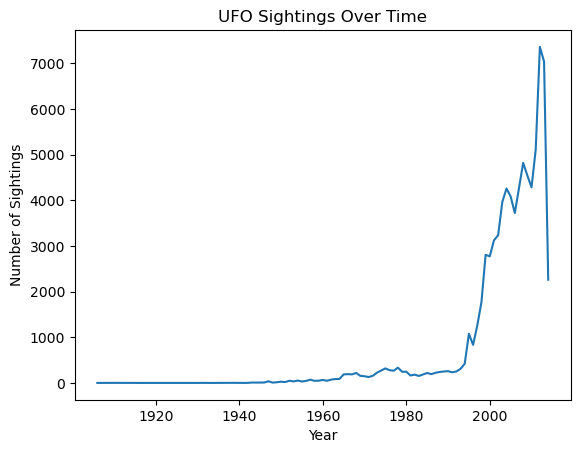

In [23]:
import matplotlib.pyplot as plt

df['datetime'] = pd.to_datetime(df['datetime'], errors='coerce')
df['year'] = df['datetime'].dt.year

# Plotting the trend
df.groupby('year').size().plot(kind='line')
plt.title('UFO Sightings Over Time')
plt.xlabel('Year')
plt.ylabel('Number of Sightings')
plt.show()


The number of sightings grows exponentially from 1994 until 2004 and then oscillates, reaching a higher peak in 2013 and then dropping fastly. Amusingly, this coincides with the rising popularity of the TV show "The X files", which started airing in 1993 and achieved extreme success in the mid and late 90s. The plot also hints waves of sightings in the late 60s and 70s. 

It is interesting to contrast this information with a plot reflecting the increase of space debris over time (source: NASA). 

<img src="./nasa.png" width="600" height="500" alt="description">

Space derbis has considerably increased since the 60s and has a cumulative tendency. This may explain the seemingly growing trend of the reported events, assuming that at least some percentage of them are related to space debris. 

### Distribution over the year

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns  

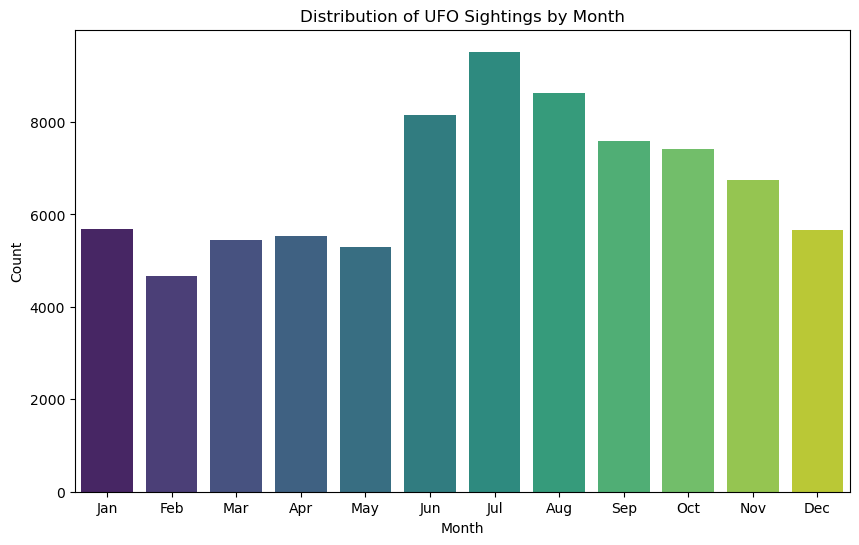

In [27]:
# Create a bar plot for the distribution of events over the months
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='month', palette='viridis')
plt.title('Distribution of UFO Sightings by Month')
plt.xlabel('Month')
plt.ylabel('Count')
plt.xticks(range(0, 12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

plt.show()


Summer is the seasons when more sightings are reported. The numbers decrease over the fall until spring.

Let us now have a look at how sightings are distribute over the days of the week and the time of the day.

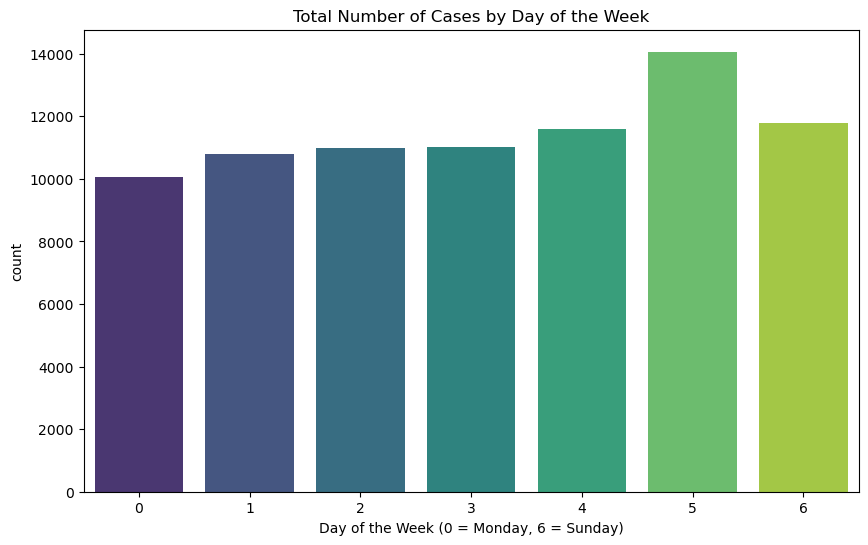

In [39]:
# Create a new column for the day of the week (0 = Monday, 6 = Sunday)
df['day_of_week'] = df['datetime'].dt.dayofweek

# Create a bar plot for the total number of cases by day of the week
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='day_of_week', palette='viridis')
plt.title('Total Number of Cases by Day of the Week')
plt.xlabel('Day of the Week (0 = Monday, 6 = Sunday)')
plt.show()

The number of sightings are very similarly distributed over the days of the week, with the weekend days having a slightly predominant position, in particular Saturdays. A possible explanation is that people typically have their spare time on weekends and tend to spend more time outdoors, particularly on Saturday evenings. These conditions facilitate the sighting of any anomaly in the sky. 

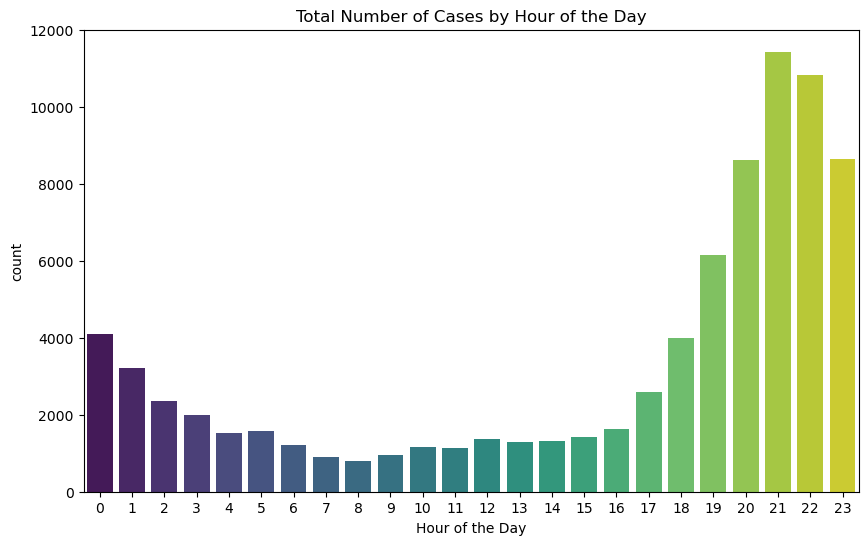

In [40]:
# Create a bar plot for the total number of cases by hour of the day
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='hour', palette='viridis')
plt.title('Total Number of Cases by Hour of the Day')
plt.xlabel('Hour of the Day')
plt.show()

Most sightings occur in the time frame from 6pm to 12am. Maybe the reason is that during the daytime it is more difficult to discern the light signals associated with a UFO sighting. Another explainign factor is that people tend to look up to the sky more frequently in the nigthtime, as during the day we are busier going to work, doing the groceries, etc.

### Geographical distribution

Next, we can create a map to show the geographical distribution of sightings. For this purpose, we will rename the column corresponding to the longitude, which was originally typed with a space in the end, as we can check here:

C:\Users\sergi\AppData\Local\Temp\ipykernel_13860\2973121459.py:10: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


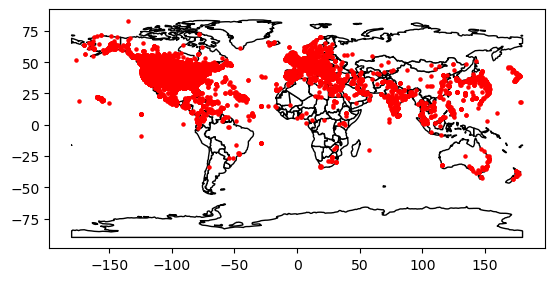

In [28]:
import geopandas as gpd
from shapely.geometry import Point

# Converting locations to geographic coordinates (this requires geocoding)
df['geometry'] = df.apply(lambda row: Point(float(row['longitude']), float(row['latitude'])), axis=1)
gdf = gpd.GeoDataFrame(df, geometry='geometry')

# Plotting the map
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
base = world.plot(color='white', edgecolor='black')
gdf.plot(ax=base, marker='o', color='red', markersize=5)
plt.show()


The majority of events seem to occur in North America and Europe. Let us find out what countries concretely:

In [29]:
df.country.value_counts()

country
us    65114
ca     3000
gb     1905
au      538
de      105
Name: count, dtype: int64

Most of the cases occur in the US. Note that there are rows where the country is not reported but the location was. 

In [30]:
import plotly.express as px

country_group = df.groupby('country')['country'].count().sort_values(ascending=False)
fig = px.bar(country_group, title='Total cases by country', color = country_group.index,
             width=800, height=800)

fig.update_layout(
    xaxis_title="Country",
    yaxis_title="Count"
)

fig.show()



We can further determine the top 10 cities for UFO sightings:

In [31]:
df_city_grouped = df.groupby('city')['city'].count().nlargest(10).sort_values(ascending=False)
fig = px.bar(df_city_grouped, title='Total cases by city', color = df_city_grouped.index, 
       width=800, height=800)

fig.update_layout(
    xaxis_title="City",
    yaxis_title="Count"
)

fig.show()



And also investigate the sighting distribution by state:

In [32]:
df_city_grouped = df.groupby('state')['state'].count().nlargest(10).sort_values(ascending=False)
fig = px.bar(df_city_grouped, title='Total cases by state', color = df_city_grouped.index, 
       width=800, height=800)

fig.update_layout(
    xaxis_title="State",
    yaxis_title="Count"
)

fig.show()



### Shape distribution

Let us now focus on the UFO shapes. We want to plot the frequencies of the different shapes reported. We start by counting the number of occurrences of each shape. 

In [33]:
shape_counts = df['shape'].value_counts()

And now create a bar chart:

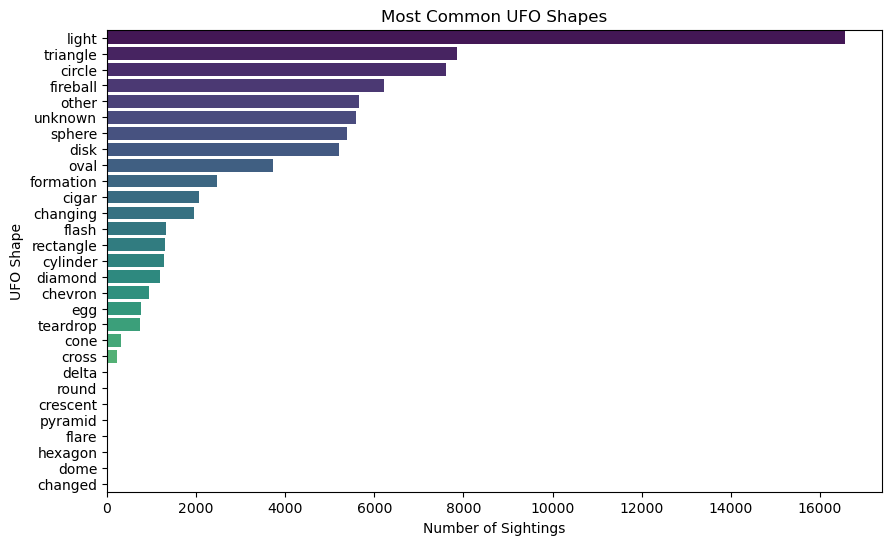

In [34]:
import seaborn as sns

# Reset index to use "shape" as a column
shape_counts_df = shape_counts.reset_index()
shape_counts_df.columns = ['shape', 'count']

# Create a bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x='count', y='shape', data=shape_counts_df, palette='viridis')

plt.title('Most Common UFO Shapes')
plt.xlabel('Number of Sightings')
plt.ylabel('UFO Shape')
plt.show()

The most frequent sightings only report lights, which may not be so impressive. The most frequently reported shapes of actual objects involved in sightings seem to be a triangle followed closely by a circle. The latter seems to be referring to the shape of flying sources that we all have in the back of our minds. The next most popular entries involve round shapes. There are relatively frequent reports of a cigar shape, which resembles the tic-tac shape seen in the footage recorded by one of the pilots that declared at the Congress hearing. 

### Wordcloud

Last, a wordcloud derived from the ``comments`` column helps in visualizing the most frequent words appearing in the reports:

In [35]:
from wordcloud import WordCloud, STOPWORDS
from nltk.corpus import stopwords

# Combine NLTK's and wordcloud's stopwords
stopwords_set = set(stopwords.words('english')) | set(STOPWORDS)

# Prepare the text data
text = " ".join(comment for comment in df['comments'].fillna(''))

# Generate a word cloud image, excluding stopwords
wordcloud = WordCloud(stopwords=stopwords_set, background_color='white').generate(text)

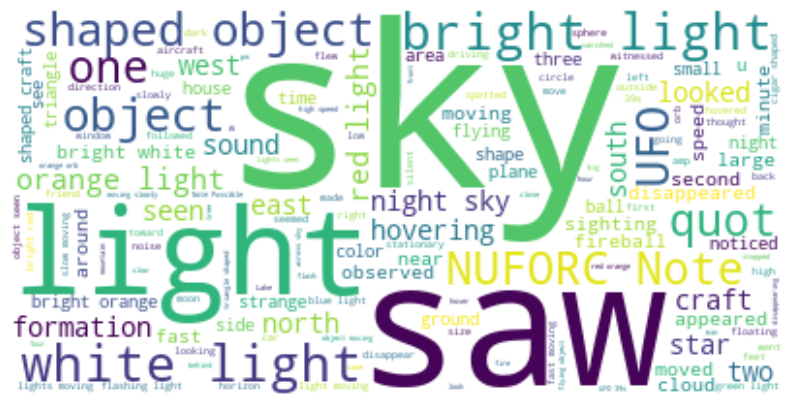

In [36]:
# Display the generated image using matplotlib
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Hide the axes
plt.show()

It is also interesting to count the number of entries in which the comments column contain some word related to armed forces or police. This is a first attempt to gauge the credibility of the report. We start by defining the set of keywords

In [37]:
keywords = ['pilot', 'police', 'army', 'military', 'navy', 'air force', 'officer', 'government', 'aviation', 'radar', 'soldier']

and then proceed to counting

In [38]:
# Ensure comments are strings to avoid errors with missing or non-string data
df['comments'] = df['comments'].astype(str)

# Initialize a counter
keyword_count = 0

# Loop through keywords and count entries containing each keyword
for keyword in keywords:
    keyword_count += df['comments'].str.contains(keyword, case=False, na=False).sum()

print(f"Number of reports including keywords: {keyword_count}")


Number of reports including keywords: 1098


This is not significant at all, given that the total nuber of reports is over 80,000. 

## Conclusions

The number of reported cases increased exponentially in the period from 1994 to 2013, reaching a highest peak in 2013 and then dropping fastly. While we can relate the increase in the number of sightings over time to the lager amount of space debris produced, it is not straightforward to come up with an explanation for the observed decrease from 2013. The rising popularity of science fiction TV shows such as "The X files" could also explain the increase of reported events: UFOs becoming a more mainstream topic results in people being less reluctant to report their experiences. 

The largest number of UFO events was reported in the US, specifically in cities that have air force bases or aircraft manufacturers nearby. States with higher statistics are California and Washigton. Along with Portland (Oregon) being the third city in number of sightings, we conclude the West Coast shows a particularly intense UFO activity. 

The season that witnesses more UFO events is the summer, whereas the most favored time of the day is the evening. Weekends seem to show a slightly higher likelihood of experiencing a UFO event compared to weekdays. 

The most reported UFO shapes are triangles and round shapes like circles and disks. From the comments column, the phenomenon seems to be quite frequently accompanied by lights. 

With all this information at hand, if we were UFO hunters an ideal location to try to observe them would be somewhere in the West Coast on a hot summer Saturday night.  




